In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
from typing import List, Dict, Any
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_tensorboard_scalars(log_file, scalar_keys, truncate_thresh=None, debug=False):
    # Initialize an EventAccumulator with the path to the log directory
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()  # Load the events from disk

    if isinstance(scalar_keys, str):
        scalar_keys = [scalar_keys]
    
    if debug:
        print(event_acc.Tags())

    # Extract the scalar summaries
    scalars = {}
    for tag in scalar_keys:
        scalars_for_tag = event_acc.Scalars(tag)
        scalars[tag] = {
            'step': [s.step for s in scalars_for_tag],
            'wall_time': [s.wall_time for s in scalars_for_tag],
            'value': [s.value for s in scalars_for_tag],
        }

    return scalars

def compute_mean_std(scalars: List[Dict[str, Any]],
                     data_key: str,
                     truncate_thresh: int,
                     ninterp=100):
    min_step = min([s for slog in scalars for s in slog[data_key]['step']])
    max_step = max([s for slog in scalars for s in slog[data_key]['step']])
    steps = np.linspace(min_step, max_step, ninterp)
    scalars_interp = np.stack([
        np.interp(steps, slog[data_key]['step'], slog[data_key]['value'], left=float('nan'), right=float('nan'))
        for slog in scalars
    ], axis=1)

    mean = np.mean(scalars_interp, axis=1)
    std = np.std(scalars_interp, axis=1)

    return steps, mean, std


def plot_mean_std(ax: plt.Axes,
                  steps: np.ndarray,
                  mean: np.ndarray,
                  std: np.ndarray,
                  name: str,
                  color: str):
    
    ax.fill_between(steps, mean-std, mean+std, color=color, alpha=0.3)
    ax.plot(steps, mean, color=color, label=name)
    ax.set_xlabel("Environment Steps")

def plot_scalars(ax: plt.Axes,
                 scalars: Dict[str, Any],
                 data_key: str,
                 name: str,
                 color: str):
    ax.plot(scalars[data_key]['step'], scalars[data_key]['value'], color=color, label=name)
    ax.set_xlabel("Environment Steps")


In [3]:
def plot(input_log_files, human_readable_names, data_key="eval_return", ylabel="eval_return", colors=None, display_errors=False, save_file=None, debug=False):
    has_names = True
    
    if not isinstance(data_key, list):
        data_key = [data_key]

    if display_errors: # just for one file
        if colors is None:
            colors = [None]

        if human_readable_names is None:
            has_names = False
            human_readable_names = [None]

        assert len(human_readable_names) == 1
        assert len(colors) == 1

        all_scalars = [extract_tensorboard_scalars(log, data_key, debug) for log in input_log_files]
        xs, mean, std = compute_mean_std(all_scalars, data_key)
        plot_mean_std(plt.gca(), xs, mean, std, data_key, human_readable_names[0], colors[0])
    else:
        if colors is None:
            colors = [None] * len(input_log_files)

        if human_readable_names is None:
            has_names = False
            human_readable_names = [None] * len(input_log_files)

        assert len(human_readable_names) == len(input_log_files) * len(data_key)
        assert len(colors) == len(input_log_files)

        i = 0
        for log, color in zip(input_log_files, colors):                
            for dk in data_key:
                if "hw2" in log:
                    scalars = extract_tensorboard_scalars(log, "Eval_AverageReturn", debug)
                    plot_scalars(plt.gca(), scalars, "Eval_AverageReturn", human_readable_names[i], color, old=True)
                else:
                    scalars = extract_tensorboard_scalars(log, dk, debug)
                    plot_scalars(plt.gca(), scalars, dk, human_readable_names[i], color)
                i += 1

    plt.ylabel(ylabel)
    if has_names:
        plt.legend(bbox_to_anchor=(1.04, 0.6), loc="upper left")

    if save_file:
        plt.savefig(save_file)
    plt.show()

## Q2.4

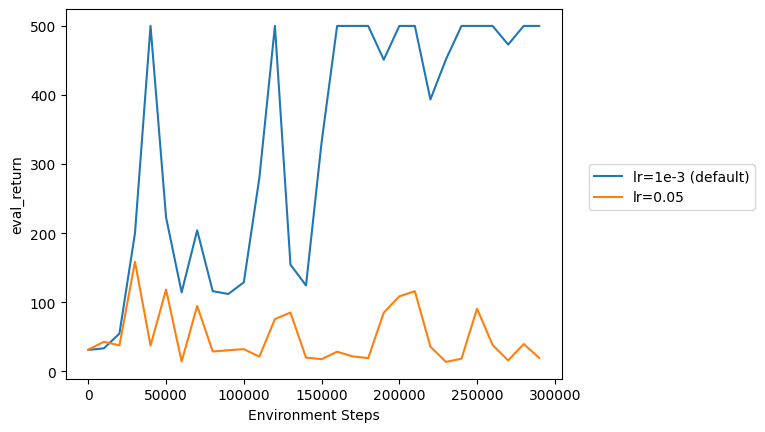

In [4]:
# CartPole
cartpole_files = ["data/hw3_dqn_dqn_CartPole-v1_l2_21-10-2023_15-07-48",
                  "data/hw3_dqn_dqn_CartPole-v1_l2_21-10-2023_15-08-40"]
cartpole_names = ["lr=1e-3 (default)",
                  "lr=0.05"]
plot(cartpole_files, cartpole_names)

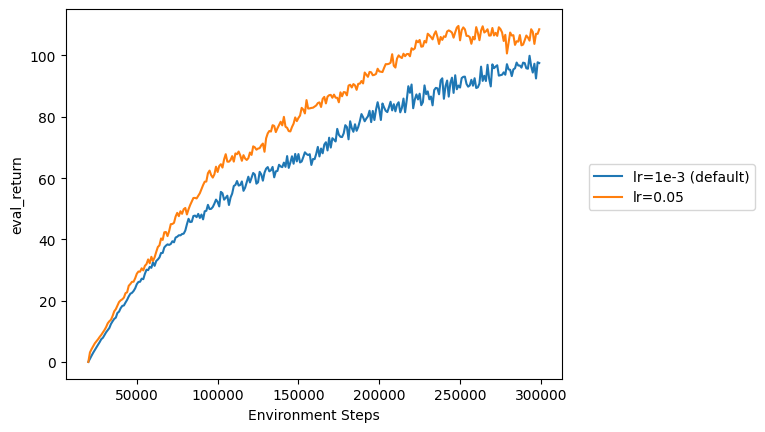

In [5]:
plot(cartpole_files, cartpole_names, data_key="q_values")

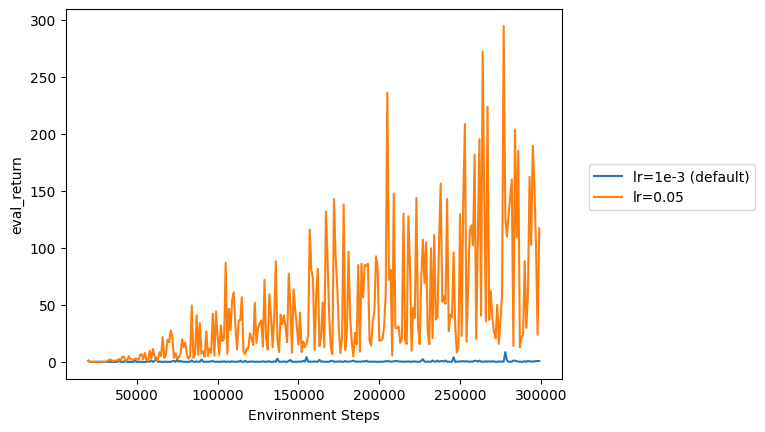

In [6]:
plot(cartpole_files, cartpole_names, data_key="critic_loss")

## Q2.5

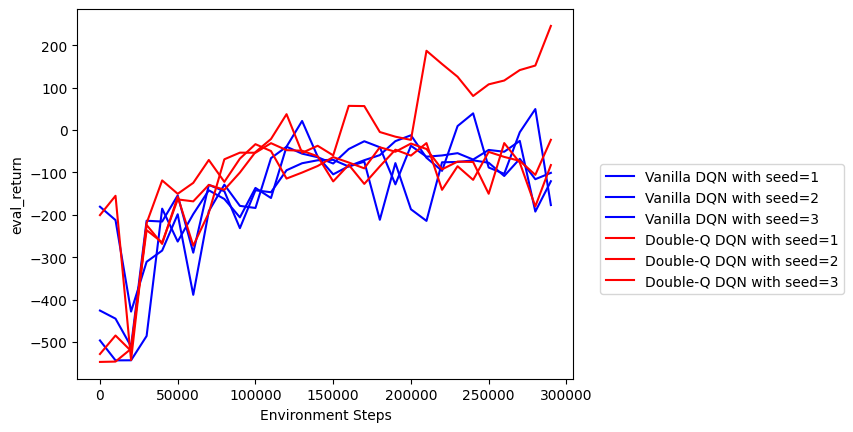

In [7]:
# Lunarlander
lunarlander_files = ["data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_20-10-2023_00-43-44_q2.4",
                     "data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_20-10-2023_00-44-25_q2.4",
                     "data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_20-10-2023_00-44-48_q2.4",
                     "data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_doubleq_20-10-2023_01-28-32_q2.5",
                     "data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_doubleq_20-10-2023_01-29-01_q2.5",
                     "data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_doubleq_20-10-2023_01-29-14_q2.5"]
lunarlander_names = ["Vanilla DQN with seed=1",
                     "Vanilla DQN with seed=2",
                     "Vanilla DQN with seed=3",
                     "Double-Q DQN with seed=1",
                     "Double-Q DQN with seed=2",
                     "Double-Q DQN with seed=3"]
colors = ["blue"] * 3 + ["red"] * 3
save_file = "q2.5_lunarlander.png"
plot(lunarlander_files, lunarlander_names, colors=colors)

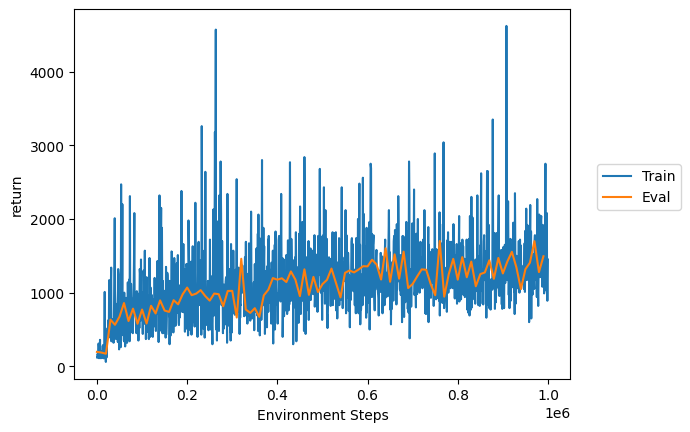

In [8]:
# Pacman
pacman_files = ["data/hw3_dqn_dqn_MsPacmanNoFrameskip-v0_d0.99_tu2000_lr0.0001_doubleq_clip10.0_20-10-2023_01-30-06_q2.5"]
pacman_names = ["Train", "Eval"]
data_key = ["train_return", "eval_return"]
ylabel = "return"
plot(pacman_files, pacman_names, data_key=data_key, ylabel=ylabel)

## Q2.6

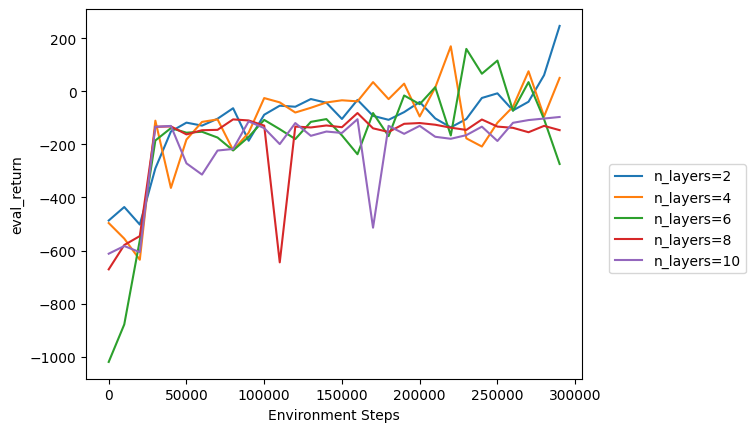

In [9]:
# Lunarlander
lunarlander_files = ["data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_20-10-2023_01-45-01_q2.6",
                     "data/hw3_dqn_dqn_LunarLander-v2_s64_l4_d0.99_20-10-2023_02-12-06_q2.6",
                     "data/hw3_dqn_dqn_LunarLander-v2_s64_l6_d0.99_20-10-2023_02-29-58_q2.6",
                     "data/hw3_dqn_dqn_LunarLander-v2_s64_l8_d0.99_20-10-2023_02-48-40_q2.6",
                     "data/hw3_dqn_dqn_LunarLander-v2_s64_l10_d0.99_20-10-2023_03-05-15_q2.6"]
lunarlander_names = ["n_layers=2",
                     "n_layers=4",
                     "n_layers=6",
                     "n_layers=8",
                     "n_layers=10"]
save_file = "q2.6_lunarlander_tuning.png"
plot(lunarlander_files, lunarlander_names)

## Q3.1.3

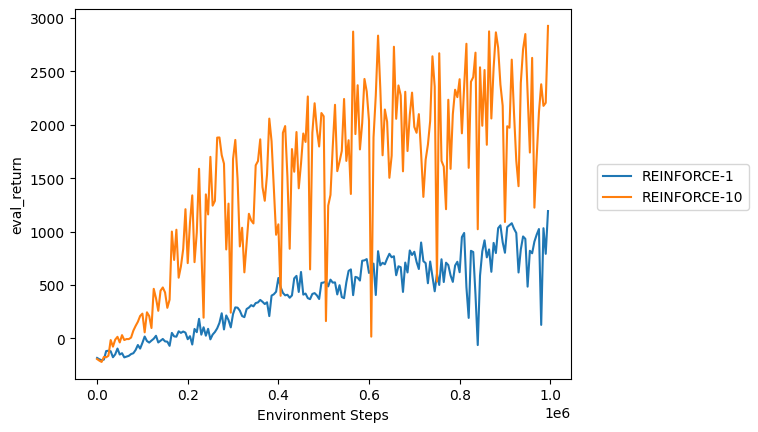

In [10]:
# HalfCheetah
halfcheetah_files = ["data/hw3_sac_reinforce1_HalfCheetah-v4_reinforce_l3_alr3e-05_clr3e-05_t0.1_stu0.005_21-10-2023_12-35-14",
                     "data/hw3_sac_reinforce10_HalfCheetah-v4_reinforce_s128_l3_alr0.0003_clr0.0003_b128_d0.99_t0.2_stu0.005_20-10-2023_03-14-55"]
halfcheetah_names = ["REINFORCE-1",
                     "REINFORCE-10"]
save_file = "q3.1.3_halfcheetah.png"
plot(halfcheetah_files, halfcheetah_names)

## Q3.1.4

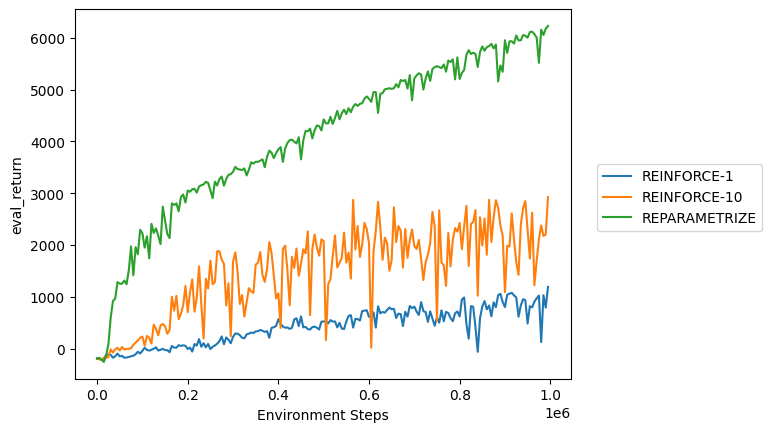

In [11]:
# HalfCheetah
halfcheetah_files = ["data/hw3_sac_reinforce1_HalfCheetah-v4_reinforce_l3_alr3e-05_clr3e-05_t0.1_stu0.005_21-10-2023_12-35-14",
                     "data/hw3_sac_reinforce10_HalfCheetah-v4_reinforce_s128_l3_alr0.0003_clr0.0003_b128_d0.99_t0.2_stu0.005_20-10-2023_03-14-55",
                     "data/hw3_sac_reparametrize_HalfCheetah-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b128_d0.99_t0.1_stu0.005_20-10-2023_03-18-43"]
halfcheetah_names = ["REINFORCE-1",
                     "REINFORCE-10",
                     "REPARAMETRIZE"]
save_file = "q3.1.4_halfcheetah.png"
plot(halfcheetah_files, halfcheetah_names)

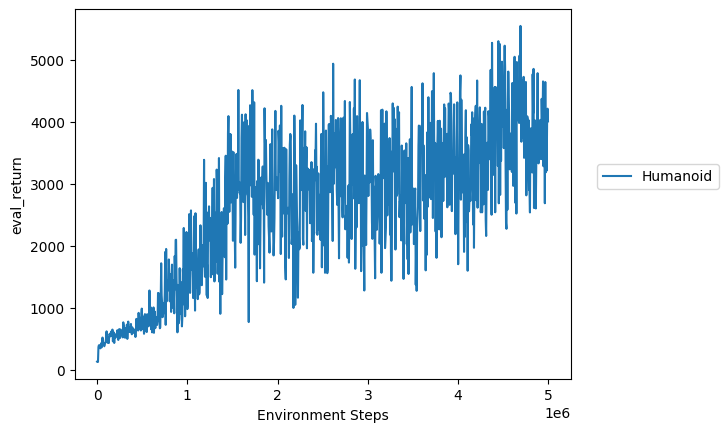

In [12]:
# Humanoid
humanoid_file = ["data/hw3_sac_sac_humanoid_Humanoid-v4_reparametrize_s256_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_min_20-10-2023_03-20-00"]
humanoid_name = ["Humanoid"]
save_file = "q3.1.4_humanoid.png"
plot(humanoid_file, humanoid_name)

## Q3.1.5

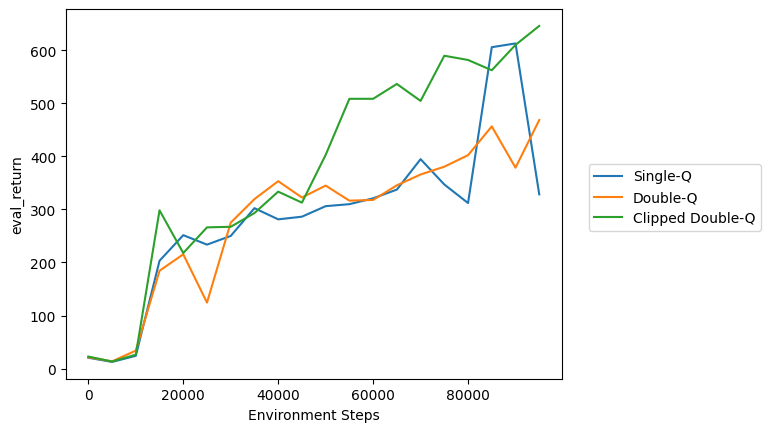

In [13]:
# Hopper
hopper_files = ["data/hw3_sac_sac_hopper_singlecritic_Hopper-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_20-10-2023_04-27-21",
                 "data/hw3_sac_sac_hopper_doubleq_Hopper-v4_reparametrize_l3_alr0.0003_clr0.0003_t0.05_stu0.005_doubleq_21-10-2023_11-52-50",
                 "data/hw3_sac_sac_hopper_clipq_Hopper-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_min_20-10-2023_04-54-14"]
hopper_names = ["Single-Q",
                 "Double-Q",
                 "Clipped Double-Q"]
save_file = "q3.1.5_hopper_evalreturn.png"
plot(hopper_files, hopper_names)

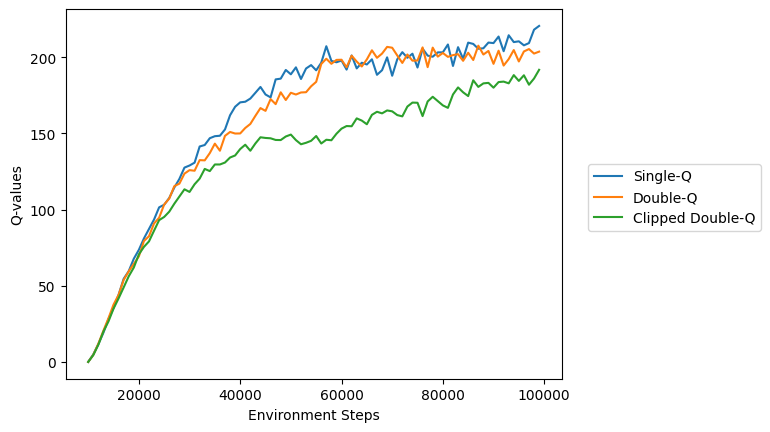

In [14]:
save_file = "q3.1.5_hopper_qvalues.png"
plot(hopper_files, hopper_names, data_key="q_values", ylabel="Q-values")

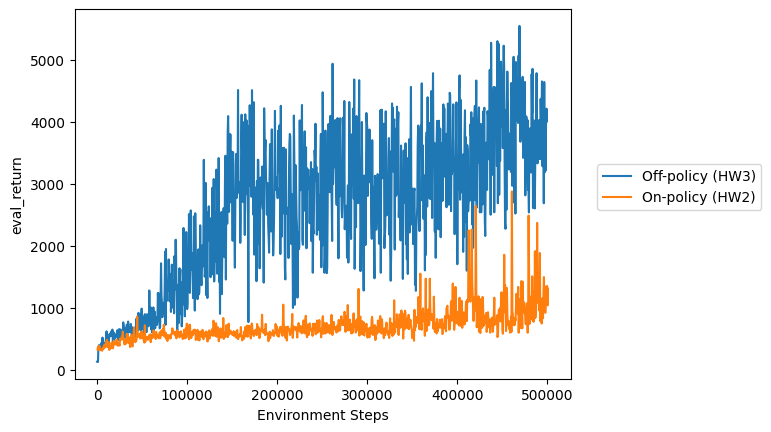

In [15]:
# Humanoid
file_paths = ["data/hw2_humanoid",
              "data/hw3_sac_sac_humanoid_Humanoid-v4_reparametrize_s256_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_min_20-10-2023_03-20-00"
              ]
def viz(ada_file):
    event_acc = EventAccumulator(ada_file)
    event_acc.Reload()
    value = [scalar.value for scalar in event_acc.Scalars('eval_return')]
    step = [scalar.step for scalar in event_acc.Scalars('eval_return')]
    return value, step 


value_h, step_h = viz(file_paths[1])
step_h = [step* 10 for step in step_h]
event_acc = EventAccumulator(file_paths[0])
event_acc.Reload()
value_h2 = [scalar.value for scalar in event_acc.Scalars('Eval_AverageReturn')]
step_h2 = [int(scalar.value) for scalar in event_acc.Scalars('Train_EnvstepsSoFar')]
value_h2 = value_h2[:len(value_h)]
step_h2 = step_h2[:len(step_h)]
truncate_thresh = int(5e5)
plt.figure()
plt.plot(np.array(step_h) / 100, value_h, label="Off-policy (HW3)")
plt.plot(np.array(step_h2) / 100, value_h2, label="On-policy (HW2)")
plt.xlabel("Environment Steps")
plt.ylabel("eval_return")
plt.legend(bbox_to_anchor=(1.04, 0.6), loc="upper left")